## Подключение к базе. Загрузка таблицы sql

In [9]:
#!pip install pandas-profiling conda install
#!conda install -c conda-forge pandas-profiling

In [10]:
#!pip install scikit-plot

Импортируем все необходимые библиотеки:

In [11]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as ltb
import scikitplot as skplt
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


Для подключения к базе данных нам понадобится:

* имя пользователя базы данных и пароль;

* адрес сервера базы данных, включая порт;

* название базы данных.

Эти данные для удобства записашем в объект:

In [12]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
 

Сформируем строку для подключения с помощью метода `.format()`:

In [13]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

Создадим соединение: для этого строку с данными для подключения передадим функции `create_engine()`:

In [14]:
engine = create_engine(connection_string) 

### Вывод 

Подключились к базе данных.


## Первичное исследование таблиц

Теперь изучим, все ли таблицы имеют набор данных и общий ключ для связи.
Для этого запишем запрос в переменную query и извлечем результаты SQL-запроса в переменные соответствующие названиям таблиц:

Согласно ER-диаграмме у нас есть 4 таблицы: case_ids, vehicles, collisions и parties. Начнем с case_ids:

In [15]:
query = '''
SELECT *
FROM case_ids
'''

In [16]:
case_ids = pd.read_sql_query(query, con = engine) 
case_ids.head()

case_id db_year
0  0081715    2021
1  0726202    2021
2  3858022    2021
3  3899441    2021
4  3899442    2021

Согласно ER-диаграмме таблица должна была содержать 2 поля: первичный ключ case_id и текстовое поле Case_id. Но вместо последнего у нас есть столбец 'db_year'. Посмотрим, информативен ли он. Для этого выведем все его уникальные значения:

In [17]:
query = '''
SELECT DISTINCT db_year
FROM case_ids
'''

In [18]:
display(pd.read_sql_query(query, con = engine) )

db_year
0    2021

Значит, таблица case_ids не имеет весь набор данных, который должна иметь исходя из условия.

Далее перейдем к таблице vehicles, которая содержит информацию о пострадавших машинах. Для краткого знакомства с данными в таблице нам не нужно выводить на экран всю таблицу. Поэтому в целях быстрого выполнения запроса ограничим количество строк в SQL-запросе до 20:

In [19]:
query = '''
SELECT *
FROM vehicles
LIMIT 20
'''

In [20]:
vehicles = pd.read_sql_query(query, con = engine) 
vehicles.head()

id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5

Как видим, в таблице 6 столбцов:

* id - уникальный идентификатор записи таблицы, первичный ключ.


* case_id - Внешний ключ, неуникальный номер для зарегистрированного происшествия, который связывает с таблицей collisions.


* party_number - Внешний ключ, неуникальный номер участника происшествия, который сопоставляется с таблицей parties.

При этом `сочетание столбцов 'case_id' и 'party_number'` дает уникальный идентификатор.

* vehicle_type - Тип кузова.


* vehicle_transmission - Тип КПП.


* vehicle_age - Возраст автомобиля (в годах).



Теперь рассмотрим таблицу collisions, которая содержит общую информация о ДТП. 
Также как и с предыдущей таблицей, ограничим количество строк в SQL-запросе 20:

In [21]:
query = '''
SELECT *
FROM collisions
LIMIT 20
'''

In [22]:
collisions = pd.read_sql_query(query, con = engine) 
collisions.head()

case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         sideswipe   
1   vehicle code violation         improper passing        hit object   
2   vehicle code violation         improper turning         broadside   
3   vehicle code violation  automobile right of way         broadside   
4   vehicle code violation                 speeding          rear end   

  motor_vehicle_involved_with road_surface road_condition_1  \
0         other motor vehicle          wet           normal   
1                fixed object          dry           normal   
2         other motor vehicle          dry           normal   
3         other motor vehicle          dry           normal   
4         other motor vehicle          dry             None   

                  lighting control_device collision_date collision_time  
0                 daylight           none     2009-01-22       07:25:00  
1  dark with street lights    functioning     2009-01-03       02:26:00  
2  dark with street lights    functioning     2009-01-11       03:32:00  
3                 daylight    functioning     2009-01-11       10:35:00  
4  dark with street lights    functioning     2009-01-02       22:43:00

Таблица содержит следующие колонки:

* case_id - Уникальный номер для зарегистрированного происшествия в таблице происшествий. Первичный ключ для таблицы и внешний для остальных (связывает с другими таблицами)


* county_city_location - Номер географических районов, где произошло ДТП


* county_location	- Названия географических районов, где произошло ДТП


* distance	- Расстояние от главной дороги (метры)


* direction	- Направление движения


* intersection	- Является ли место происшествие перекрёстком


* weather_1	- Погода


* location_type - Тип дороги


* collision_damage	- Серьёзность происшествия


* party_count - Количество участников


* primary_collision_factor	- Основной фактор аварии


* pcf_violation_category - Категория нарушения


* type_of_collision	- Тип аварии


* motor_vehicle_involved_with - Дополнительные участники ДТП


* road_surface - Состояние дороги


* road_condition_1	- Дорожное состояние 


* lighting	- Освещение


* control_device - Устройство управления (в описании обозначена как 'CONTROL_CONDITION_1') 


* collision_date - Дата происшествия


* collision_time - Время происшествия

Теперь перейдем к таблице parties, которая содержит информацию об участниках ДТП:

In [23]:
#чтобы не умер kernel ограничим 20 строками для вывода
query = '''
SELECT *
FROM parties
LIMIT 20
'''

In [24]:
parties = pd.read_sql_query(query, con = engine)
parties.head()

id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None               0.0  
1  had not been drinking                None               0.0  
2  had not been drinking                None               0.0  
3  had not been drinking                None               0.0  
4         not applicable      not applicable               0.0

Таблица содержит следующие столбцы:

* id  - Идентификационный  номер записи в таблице. Первичный ключ.

* case_id - неуникальный номер для зарегистрированного происшествия в таблице происшествий. Внешний ключ. Связывает с таблицей collisions

* party_number - Номер участника происшествия

Если нужен уникальный идентификатор, то это `сочетание 'case_id' and 'party_number'`.

* party_type - Тип участника происшествия

* at_fault - Виновность участника

* insurance_premium	- Сумма страховки (тыс. $)

* party_sobriety - Трезвость участника

* party_drug_physical - Состояние участника: физическое или с учётом принятых лекарств

* cellphone_in_use  - Наличие телефона в автомобиле (возможности разговаривать по громкой связи)

### Вывод

* Только таблица case_ids не имеет весь набор данных, который должна иметь исходя из условия.


* Согласно ER-диаграмме у нас есть 4 таблицы: case_ids, vehicles, collisions и parties. Таблица case_ids не была указана в условии задачи, однако есть на ER-диаграмме. Поэтому количество таблиц не соответствует условию задачи (их больше).


* Все таблицы связаны с таблицей collisions с помощью внешнего ключа case_id. При этом vehicles связана с таблицей parties сочетаниями столбцов 'case_id' and 'party_number'.

##  Статистический анализ факторов ДТП

### Месяцы наибольшего количества аварий

Выясним, в какие месяцы происходит наибольшее количество аварий. Для этого проанализируем весь период наблюдений (таблица collisions).

Создадим sql-запрос, который покажет подсчитает количество ДТП для каждого месяца:


In [109]:
query = '''
SELECT DISTINCT DATE_TRUNC('month', collision_date)::TIMESTAMP AS collision_month, 
       COUNT(case_id) OVER(PARTITION BY DATE_TRUNC('month', collision_date)::DATE  ) AS collisions_number
FROM collisions
;
'''

In [116]:
crashes_month = pd.read_sql_query(query, con = engine)

Теперь построим графики для каждого года:

/tmp/ipykernel_32/2061204365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_year['collision_month']=crashes_year['collision_month'].astype('string')


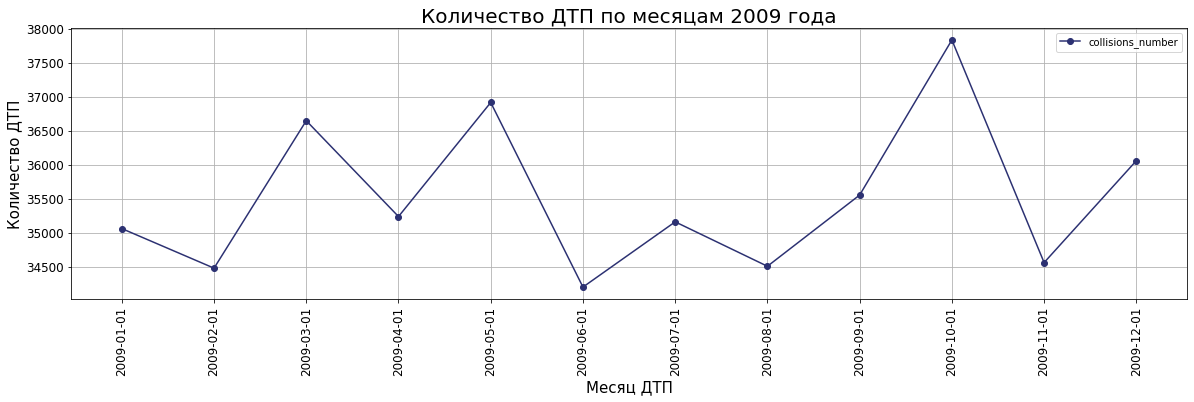

/tmp/ipykernel_32/2061204365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_year['collision_month']=crashes_year['collision_month'].astype('string')


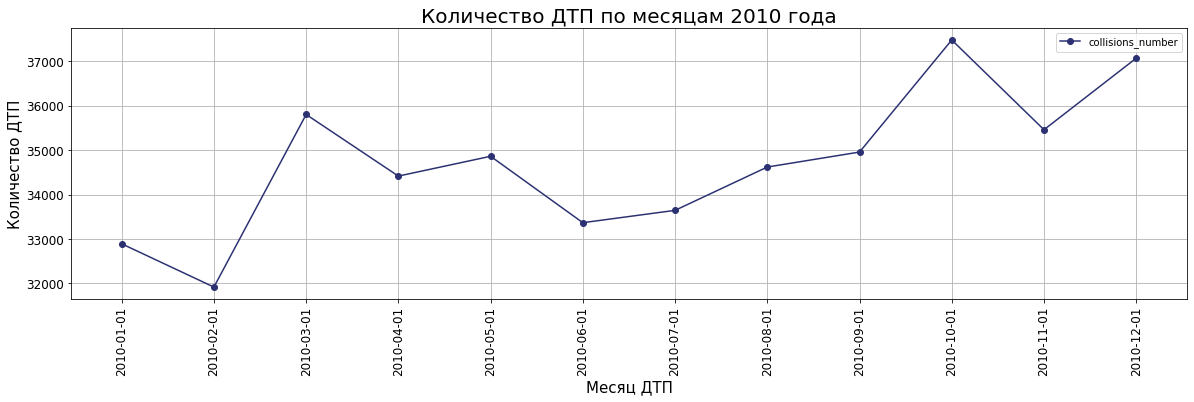

/tmp/ipykernel_32/2061204365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_year['collision_month']=crashes_year['collision_month'].astype('string')


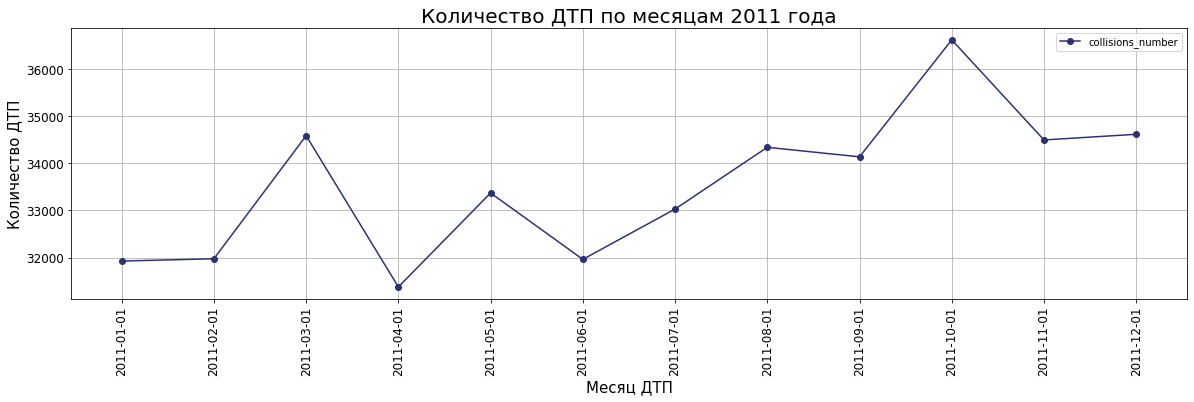

/tmp/ipykernel_32/2061204365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_year['collision_month']=crashes_year['collision_month'].astype('string')


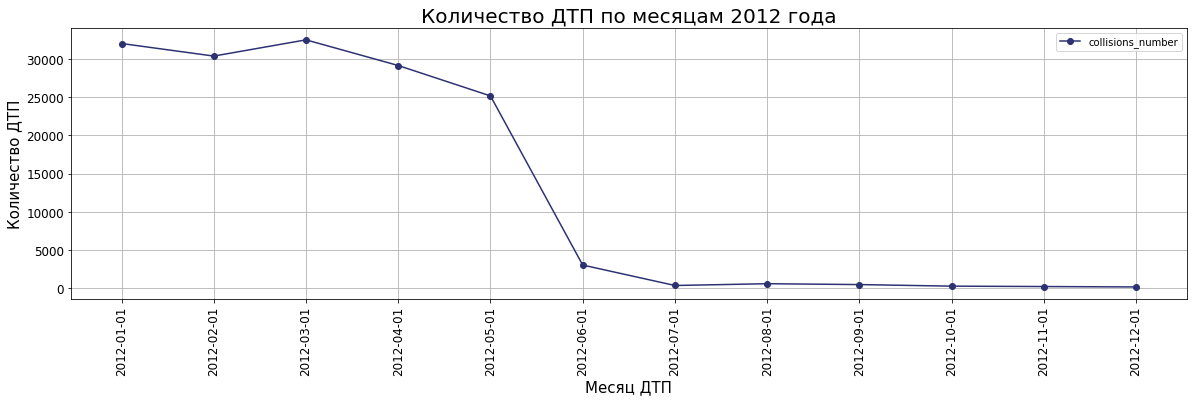

/tmp/ipykernel_32/2061204365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_year['collision_month']=crashes_year['collision_month'].astype('string')


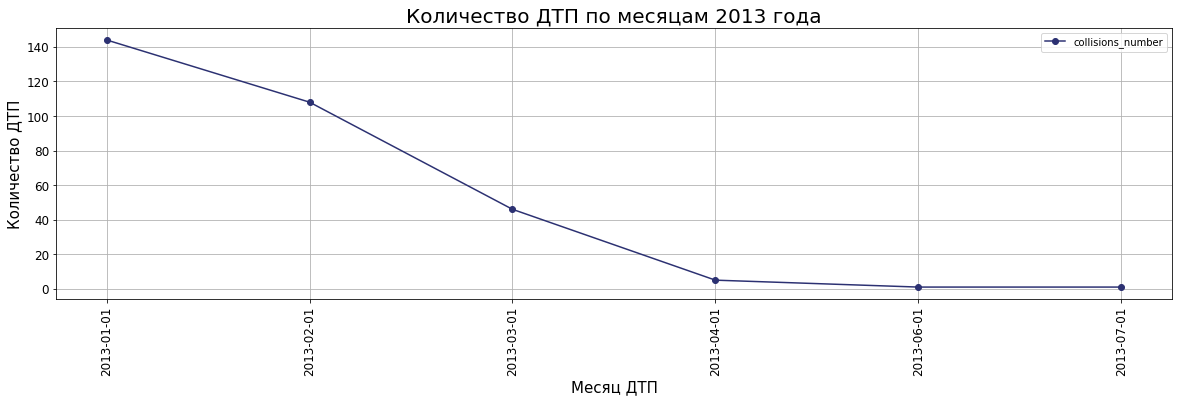

/tmp/ipykernel_32/2061204365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_year['collision_month']=crashes_year['collision_month'].astype('string')


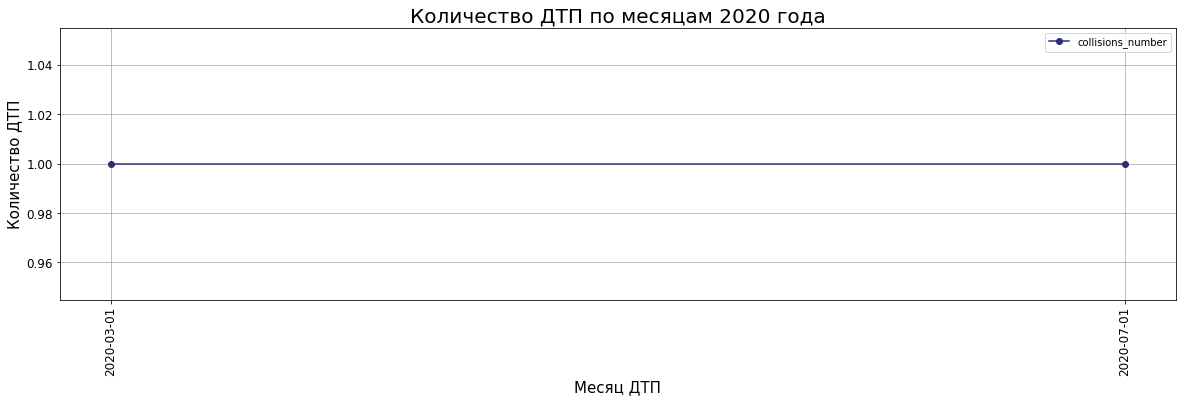

In [117]:
years = [2009, 2010, 2011, 2012, 2013, 2020]
for year in years:
    crashes_year = test[crashes_month['collision_month'].dt.year==year]
    crashes_year['collision_month']=crashes_year['collision_month'].astype('string')
    crashes_year.plot(x=('collision_month'), rot=90, figsize=(20,5), style='o-', grid=True, fontsize=12, colormap='crest_r')
    plt.xticks(np.arange(len(crashes_year)), crashes_year['collision_month'])
    plt.title(f'Количество ДТП по месяцам {year} года', fontsize = 20)
    plt.xlabel('Месяц ДТП', fontsize = 15)
    plt.ylabel('Количество ДТП', fontsize = 15)
    plt.show()
            

Не будем учитывать данные за 2013 и 2020 год, так как они не содержат данных за все 12 месяцев года.Поэтому будем анализировать только 2009-2012 года. 

Как видно из графика, наибольшее количество ДТП случилось в следующих месяцах:

* 2009 год: октябрь, май, март

* 2010 год: октябрь, декабрь, март

* 2011 год: октябрь, декабрь, март

* 2012 год: март, январь, февраль


Исходя из данных за 4 года, наибольшее количество ДТП происходит в марте (4) и октябре(3). Это объясняется тем, что в эти месяцы можно наблюдать резкую смену погоды и температуры в течение суток или даже часов, что в свою очередь влияет на видимость, состояние дороги (гололедица), управляемость и т.д.

### Aналитические задачи для коллег

1) Проведите анализ серьёзности повреждений транспортного средства исходя из физического состояния водителя в момент ДТП (связать collisions и parties);

2) Среди виновников ДТП проведите анализ взаимосвязи возраста автомобилей и количества аварий в период с 2009 по 2012 год. (vehicles, parties и collisions). 

3) Найдите самые частые причины ДТП (таблица collisions, столбец primary_collision_factor).

4) Подсчитать количество ДТП по месяцам для каждого года с накоплением.

5) Найти наиболее опасное состояние дорог, повлекшее за собой наибольшее количесто ДТП.

6) Влияет ли на количество ДТП наличие в автомобиле возможности говорить по громкой связи?

### Решение задач

**Задача №1**:**

Проведите анализ серьёзности повреждений транспортного средства исходя из физического состояния водителя в момент ДТП (связать collisions и parties)

**Решение:**

Создадим sql-запрос:

In [20]:
query = '''

SELECT DISTINCT p.party_drug_physical,
       c.collision_damage,
       COUNT(c.case_id) OVER(PARTITION BY p.party_drug_physical, collision_damage)
FROM collisions AS c
INNER JOIN parties AS p
ON c.case_id = p.case_id
WHERE p.party_type = 'car'

'''
df = pd.read_sql_query(query, con = engine)

Проверим полученную таблицу на наличие пропусков:

In [21]:
df.isna().sum()

party_drug_physical    5
collision_damage       0
count                  0
dtype: int64

Как видим, в столбце 'party_drug_physical' есть пропуски. С помощью метода value_counts и атрибута dropna=False, посчитаем какие значения включены в нашу таблицу и сравним с изначальным описанием таблицы parties, а именно столбца party_drug_physical:

In [22]:
df['party_drug_physical'].value_counts(dropna=False)

NaN                      5
under drug influence     5
G                        5
not applicable           5
sleepy/fatigued          5
impairment - physical    5
Name: party_drug_physical, dtype: int64

В описании у нас указаны следующие типы трезвости участников:

* "E — Under Drug Influence (Под воздействием лекарств)"
* "F — Impairment — Physical (Ухудшение состояния)"
* "G — Impairment Unknown (Не известно)"
* "H — Not Applicable (Не оценивался)"
* "I — Sleepy/Fatigued (Сонный/Усталый)"
* "- — Not Stated (Не указано)"

Если сравнить с тем, что мы получили в результате вызова value_counts, то можно сделать вывод о том, что пропуски это ничто иное как тип трезвости участника "- — Not Stated (Не указано)". Поэтому заполним их 'not stated':

In [23]:
df = df.fillna('not stated')

Построим графики для каждого из типов физического состояния:

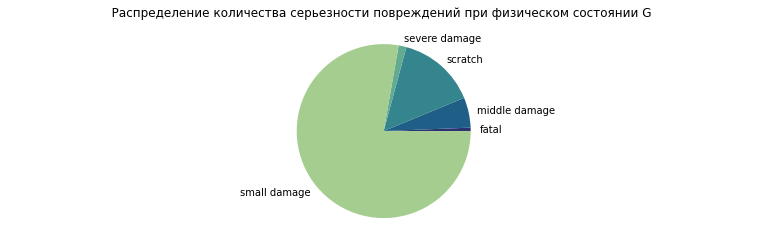

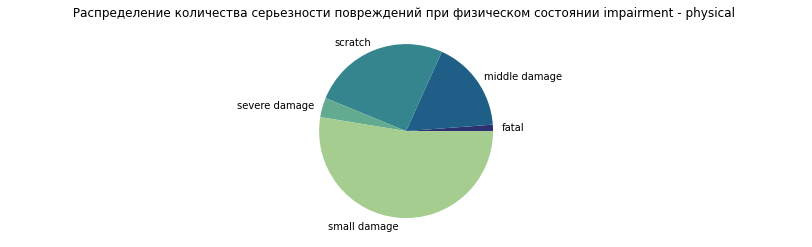

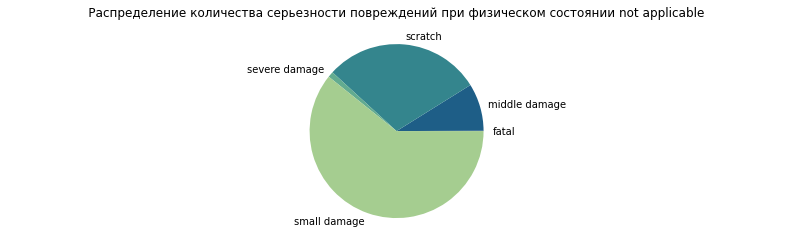

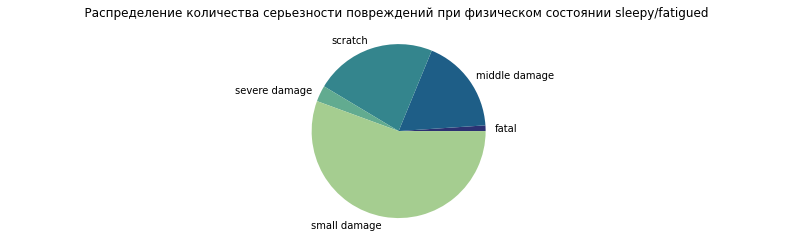

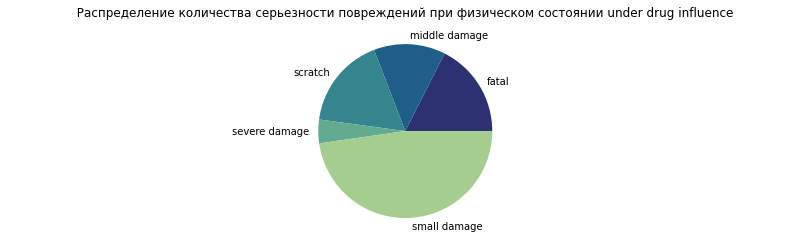

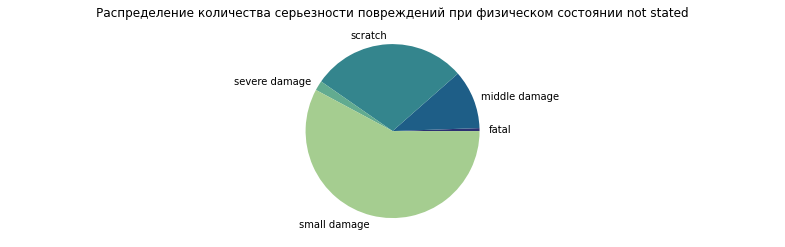

In [24]:
items = df['party_drug_physical'].unique()
for physical_type in items:
    table = df[df['party_drug_physical']==physical_type].drop(['party_drug_physical'], axis=1).set_index('collision_damage')
    table.plot.pie(subplots=True, legend=False, colormap='crest_r', normalize=True)
    title = f'Распределение количества серьезности повреждений при физическом состоянии {physical_type}'.center(130)
    plt.title(title, loc='center')
    plt.ylabel('')
    plt.show()
    

Можно сделать вывод, что:

1) Распределение серьезности повреждений при физическом состоянии  not applicable (Не оценивался) и not stated (Не указано) -  практически идентичное: Порядка 60% повреждения составляет small damage (Отдельный элемент кузова под замену/покраску), порядка трети - scratch (царапины). При этом доля severe damage (серьезный ремонт) fatal(не подлежит восстановлению) - минимальна.

2) Похожи между собой и на предыдущую группу  распределения серьезности повреждений при физическом состоянии sleepy/fatigued (Сонный/Усталый) и impairment — physical (Ухудшение состояния). Разница от предыдущей группы в том, что при sleepy/fatigued и impairment — physical существенно возрастает доля middle damage (Средний ремонт) и становится сопоставимой с долей scratch. При этом доля severe damage и fatal находится на низком уровне, но при физическом состоянии impairment — physical она выше, чем при sleepy/fatigued.


3) Отличается от всех распределение серьезности повреждений при физическом состоянии under drug influence (Под воздействием лекарств). Только при нем вероятность получить незначительные повреждения small damage составляет менее 50%. Более того, только в этом случае вероятность получения фатальных повреждений выше, чем царапин или middle damage, и составляет порядка 20%. 


**Задача №2**:**

Среди виновников ДТП проведите анализ взаимосвязи возраста автомобилей и количества аварий в период с 2009 по 2012 год. (vehicles и collisions)

**Решение:**

Создадим sql-запрос:


In [25]:
query = '''
WITH vehicle_age_percentage AS (
    SELECT vehicle_age, 
            COUNT(c.case_id) AS quantity
    FROM vehicles AS v
    INNER JOIN collisions AS c 
    ON v.case_id = c.case_id
    INNER JOIN parties AS p
    ON v.case_id = p.case_id AND v.party_number = p.party_number
    WHERE c.collision_date BETWEEN '2009-01-01' AND '2012-12-31'
    AND p.at_fault = 1
    GROUP BY vehicle_age
    ORDER BY vehicle_age
    )
SELECT vehicle_age,
       quantity/(SELECT SUM(quantity)
                 FROM vehicle_age_percentage)*100 AS percentage
FROM vehicle_age_percentage;

'''
df = pd.read_sql_query(query, con = engine)


Построим график:


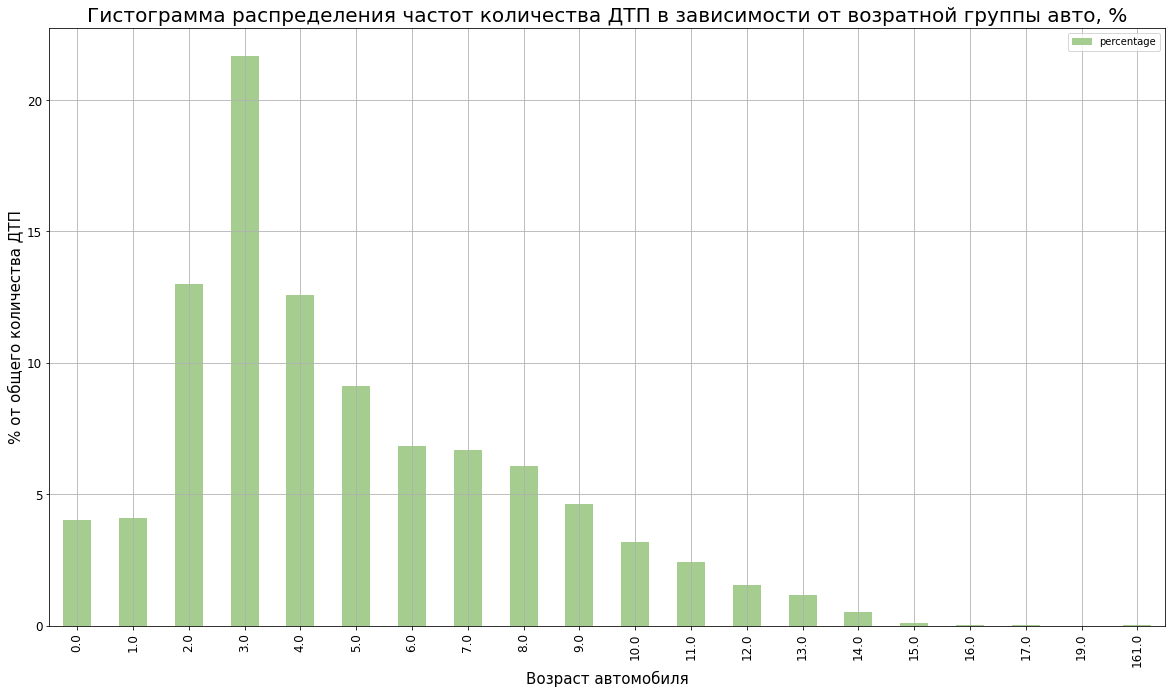

In [26]:
df.dropna().plot(kind='bar', x=('vehicle_age'),figsize=(20,11),grid=True, fontsize = 12, colormap='crest')
plt.title('Гистограмма распределения частот количества ДТП в зависимости от возратной группы авто, %', fontsize = 20)
plt.xlabel('Возраст автомобиля', fontsize = 15)
plt.ylabel('% от общего количества ДТП', fontsize = 15)
plt.show()

Из гистограммы видно, что среди виновников ДТП достаточно маленький процент приходится на новые машины (до 1 года включительно). Это можно объяснить тем, что при покупке нового автомобиля водители им дорожат, стараются вести его аккуратно, избегать любых повреждений, даже мелких царапин. 

Однако мы видим, что начиная с двуххлетнего возраста автомобиля, процент участия в ДТП резко возрастает ( ~ 13% ), достигая пика в трехлетнем возрасте (~23%). Процент от общего количества ДТП для четырехлетних машин находится на уровне ~13%, что является одним из самых высоких показателей. Можно объяснить такие изменения в процентах тем, что водители  со временем меняют свое отношение к машине. И если в первые годы они очень щепетильно к ней относятся, то ближе к 2-3 годам владения ослабляется контроль, возможно, позволяется "лишнее" (например, нарушение скоростного режима). Кроме того, в около трехлетнем возрасте машины наиболее часто продаются, и возможно, ожидание продажи вляет на водителей, и они начинают относится к машине как уже не к своей.

Также из гистограммы мы видим, что с возрастом машин количество ДТП с ними уменьшается, что можно объяснить просто уменьшением количества таких машин в общем объеме.


### Вывод

* Для всех состояний водителя (кроме under drug influence) вероятность тотально разбить машину крайне мала. Более чем в 60% случаев транспортные средства требуют только незначительного ремонта (small damage). Но если водитель находится под влиянием лекарств или других веществ, то вероятность тотально разбить машину резко возрастает и составляет порядка 20%, причем вероятнее водитель разобьет машину без возможности восстановления, чем машина получит только царапины.


* Порядка в 50% случаев виновники ДТП управляли машинами в возрасте от 2 до 4 лет, при этом вероятность того, что машине ровно 3 года - около 23%. Одни из самых аккуратных водителей - те, у которых новые машины (до года включительно). Маленький процент "возрастных" машин у виновников ДТП объясняется малым количеством таких машин в общей массе.



## Создание модели для оценки водительского риска

Подготовим набор данных с помощью sql-запроса на основе первичного предположения заказчика. 
Набо данных будет содержать следующие данные:

* тип виновника — только машина (car)
* тип повреждения автомобиля — все, кроме типа SCRATCH (царапина).
* данные только за 2012 год.


In [27]:
query = '''
WITH car_at_fault AS(
    SELECT p.case_id,
           p.party_number,
           p.party_type,
           p.at_fault,
           p.insurance_premium,
           p.party_sobriety,
           p.party_drug_physical,
           p.cellphone_in_use,
           v.vehicle_age
           
    FROM parties p
    INNER JOIN vehicles v
    ON p.case_id = v.case_id AND p.party_number = v.party_number
    WHERE party_type = 'car'
    ),
scratch_2012 AS(
    SELECT *
    FROM collisions
    WHERE collision_damage !='scratch'
    AND collision_date BETWEEN '2012-01-01' AND '2012-12-31'
    )
SELECT *
FROM car_at_fault AS caf
INNER JOIN scratch_2012 AS s
ON caf.case_id = s.case_id

'''
df = pd.read_sql_query(query, con = engine)
df

case_id  party_number party_type  at_fault  insurance_premium  \
0      5125160             2        car         0               42.0   
1      5173738             2        car         0               31.0   
2      5269486             2        car         0               21.0   
3      5319820             2        car         0               31.0   
4      5329109             2        car         1               49.0   
...        ...           ...        ...       ...                ...   
56243  5668337             3        car         0               51.0   
56244  5668348             2        car         0               24.0   
56245  5668349             2        car         1               79.0   
56246  5668352             2        car         0               21.0   
56247  5668356             1        car         1               19.0   

              party_sobriety party_drug_physical  cellphone_in_use  \
0      had not been drinking                None               0.0   
1      had not been drinking                None               0.0   
2      had not been drinking                None               0.0   
3      had not been drinking                None               0.0   
4      had not been drinking                None               0.0   
...                      ...                 ...               ...   
56243  had not been drinking                None               0.0   
56244  had not been drinking                None               NaN   
56245  had not been drinking                None               0.0   
56246  had not been drinking                None               0.0   
56247  had not been drinking                None               NaN   

       vehicle_age  case_id  ... primary_collision_factor  \
0              2.0  5125160  ...   vehicle code violation   
1              5.0  5173738  ...   vehicle code violation   
2              1.0  5269486  ...                  unknown   
3              4.0  5319820  ...   vehicle code violation   
4              6.0  5329109  ...   vehicle code violation   
...            ...      ...  ...                      ...   
56243          6.0  5668337  ...   vehicle code violation   
56244          3.0  5668348  ...   vehicle code violation   
56245         12.0  5668349  ...   vehicle code violation   
56246          3.0  5668352  ...   vehicle code violation   
56247          7.0  5668356  ...   vehicle code violation   

           pcf_violation_category  type_of_collision  \
0         automobile right of way          broadside   
1                        speeding           rear end   
2                         unknown          broadside   
3                improper turning          sideswipe   
4       other hazardous violation          broadside   
...                           ...                ...   
56243                    speeding           rear end   
56244   traffic signals and signs          broadside   
56245  unsafe starting or backing           rear end   
56246     automobile right of way          broadside   
56247   traffic signals and signs          broadside   

      motor_vehicle_involved_with  road_surface road_condition_1  \
0             other motor vehicle           dry            other   
1             other motor vehicle           dry           normal   
2             other motor vehicle           dry           normal   
3             other motor vehicle           dry           normal   
4             other motor vehicle           dry           normal   
...                           ...           ...              ...   
56243         other motor vehicle           dry           normal   
56244         other motor vehicle           dry           normal   
56245         other motor vehicle           dry           normal   
56246         other motor vehicle           dry           normal   
56247         other motor vehicle           dry           normal   

                      lighting control_device  collision_date collision_time  

Проведем первичный отбор факторов, необходимых для модели. По идее заказчика, целевой признак - at_fault(виновник). Таким образом будем рассматривать признаки в разрезе того, могут ли они влиять на виновность участника до начала движения, так как в описании задания написано, что система должна оповестить водителя до начала движения.


* **case_id** - внешний ключ таблицы parties. **Не влияет на вероятность ДТП и виновность участника**


* **party_number** -  номер участника проишествия. **Не влияет на вероятность ДТП и виновность участника**


* **party_type** - тип участника проишествия. У всех только car. **Не влияет на вероятность ДТП и виновность участника**


* **at_fault - целевой признак.** 


* **insurance_premium** - размер страховки (тыс. $). Сумма зависит от стоимости автомобиля. На более дорогих машинах люди могут ездить с более высокой скоростью, чем предписано знаками. Поэтому делаем вывод, что этот признак **может влиять  на вероятность виновности участника в ДТП.**


* **party_sobriety** - трезвость участника. **Влияет на вероятность виновности участника в ДТП.**


* **party_drug_physical** - состояние участника: физическое или с учётом принятых лекарств. **Влияет на вероятность ДТП .**


* **cellphone_in_use** - наличие возможности разговаривать по громкой связи. Может увеличивать риск ДТП, так как если такой возможности нет, то если водитель будет говорить по телефону во время движения, он, вероятно, будет держать руль одной рукой или пытаться удерживать телефон плечом, отвлекаясь от вождения, чем повлечет ДТП. **Влияет на вероятность виновности участника в ДТП**


* **vehicle_age** - Возраст автомобиля (в годах). **Обязательный признак по желанию заказчика проекта.**


* **case_id** - первичный ключ таблицы collisions.**Не влияет на виновность участника ДТП.**


* **county_city_location** - номер географических районов, где произошло ДТП. Потенциально может влиять на вероятность попасть в ДТП, так как в больших городах или густо населенных районах больше машин, но на виновность водителя маровероятно оказывает влиение **Не влияет на виновность участника.**


* **county_location** - названия географических районов, где произошло ДТП. **Не влияет на виновность участника** так же, как и предыдущий признак. 


* **distance** - расстояние от главной дороги (метры) до места уже состоявшегося проишествия. **Не влияет на вероятность виновности участника в ДТП**


* **direction** - направление движения. **Не влияет на вероятность виновности участника в ДТП**


* **intersection** - является ли место происшествие перекрёстком. Описывает состоявшееся проишествие. **Не влияет на на вероятность виновности участника в ДТП**


* **weather_1** - погода. **Влияет на вероятность виновности участника в ДТП**


* **location_type** - тип дороги на котором произошло ДТП. Например, шоссе или перекресток. **Не влияет на вероятность виновности участника в ДТП**


* **collision_damage** - серьёзность происшествия. Это описание уже случившегося ДТП. И мы сделали срез данных по этому критерию. **Не влияет на виновность участника ДТП.**


* **party_count** - количество участников. Это описание уже случившегося ДТП. **Не влияет на виновность участника ДТП.**


* **primary_collision_factor** - основной фактор аварии. Это описание уже случившегося ДТП. **Не влияет на виновность участника ДТП.**

* **pcf_violation_category** - категория нарушения. Это описание уже случившегося ДТП. **Не влияет на виновность участника ДТП.**

* **type_of_collision** - тип аварии. Это описание уже случившегося ДТП. **Не влияет на виновность участника ДТП.**


* **motor_vehicle_involved_with** - дополнительные участники ДТП. Это описание уже случившегося ДТП. **Не влияет на виновность участника ДТП.**


* **road_surface** - состояние дороги, например, сухая или мокрая.  **Влияет на вероятность виновности участника в ДТП** 


* **road_condition_1** - дорожное состояние места происшествия, например, ямы или препятствия на дороге. **Не влияет на вероятность виновности участника в ДТП** 


* **lighting** - освещение.  **Влияет на вероятность виновности участника в ДТП** 


* **control_device** - устройство управления (в описании обозначена как 'CONTROL_CONDITION_1'). Если оно не исправно, то **может влиять на виновность участника ДТП.**


* **collision_date** - дата происшествия. Ранее мы выяснили, что есть месяцы, такие как март и октябрь, когда возрастает количество аварий. **Влияет на вероятность ДТП и виновность участника** 


* **collision_time** - время происшествия. Может влиять. Например, в ночное время или раннее утреннее вероятность того, что водитель едет уставший и сонный, сильно выше, чем в обеденное. **Влияет на вероятность ДТП и виновность участника.**

Удалим ненужные столбцы:

In [28]:
data = df.drop(['case_id', 'party_number', 'party_type', 'location_type', 'intersection','direction', 'collision_damage', 
                 'party_count','primary_collision_factor', 'road_condition_1','distance','pcf_violation_category', 
                 'type_of_collision', 'motor_vehicle_involved_with','county_city_location', 'county_location'], axis=1)

In [29]:
data.profile_report(progress_bar=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

На основе полученного отчета проведем статистическое исследование отобранных факторов:

* `'at_fault'`. Содержит категориальные данные. Нет пропусков, некорректных значений. значения распределены следующим образом: 1 - 50.4% , 0 - 49.6%


* `'insurance_premium'`. Содержит количественные данные. Пропущенных значений - 1%. Минимальное значение - 0, максимальное - 105. Медиана - 34, стандартное отклонение 16.33. Данные распределены со смещением вправо, наиболее часто встречается значения 19 и 21 (в 3,8% случаев). Выявлена высокая корреляция между значениями этого столбца и 'vehicle_age'. Значение 0 - аномальное значение, далее мы проверим является ли оно вероятным.


* `'party_sobriety'`. Содержит категориальные данные. В столбце есть пропуски, их количество - 1.6% от общего количества. Наиболее часто встречающееся значение 'had not been drinking' - 86.4%, наиболее редко  - 'not applicable' - 0.4%. Выявлена высокая корреляция между значениями этого столбца и 'party_drug_physical'. 


* `'party_drug_physical'`. Содержит категориальные данные. В столбце есть пропуски, их количество - 94.9% от общего количества. Это очень высокий показатель, поэтому далее нам придется удалить весь столбец, поскольку заполнение такого количества пропущенных значений может привести к неожиданным или необъективным результатам. 


* `'cellphone_in_use '`. Содержит категориальные данные. В столбце есть пропуски, их количество - 7.9% от общего количества. В столбце нет некорректных значений. Наиболее часто встречаются "0" - 90.2%, "1" - 1.9%. 


* `'vehicle_age'`. Содержит количественные данные. Пропущенных значений - 3%. Минимальное значение - 0, максимальное - 161. Медиана - 4, стандартное отклонение 3.23. Данные распределены со смещением вправо, наиболее часто встречается значения 3 (в 19.6% случаев) и 4 (12.7%). Выявлена высокая корреляция между значениями этого столбца и 'insurance_premium'. Есть аномальное значение 161 (встречается 2 раза).


* `'weather_1'`. Содержит категориальные данные. В столбце есть пропуски, их количество - 0.3% от общего количества. Наиболее часто встречающееся значение 'clear' - 80.2%, наиболее редко  - 'wind' (11 повторений, что меньше 0.1%). Выявлена высокая корреляция между значениями этого столбца и 'road_surface'. 


* `'road_surface'`. Содержит категориальные данные. В столбце есть пропуски, их количество - 0.6% от общего количества. Наиболее часто встречающееся значение 'dry' - 89.3%, наиболее редко  - 'slippery' (0.1%). Выявлена высокая корреляция между значениями этого столбца и 'weather_1'. 


* `'lighting'`. Содержит категориальные данные. В столбце есть пропуски, их количество - 0.3% от общего количества. Наиболее часто встречающееся значение 'daylight' - 67.7%%, наиболее редко  - 'dark with street lights not functioning' (0.2%). 


* `'control_device'`. Содержит категориальные данные. В столбце есть пропуски, их количество - 0.4% от общего количества. Наиболее часто встречающееся значение 'none' - 67.2%, наиболее редко  - 'obscured' - 0.1%. 


Столбцы `'collision_date', 'collision_time'` не попали отчет. Данные по ним вызовем отдельно при помощи метода describe():

In [30]:
data[{'collision_date','collision_time'}].describe(include='all')

collision_date collision_time
count           56248          56160
unique            366           1435
top        2012-03-17       15:00:00
freq              571            413

* `'collision_date'` - содержит количественные данные. Диапазон определен SQL-запросом, который мы выполнили ранее. Наиболее часто встречающееся значение - 2012-03-17 (532).


* `'collision_time'` - содержит количественные данные. Наиболее часто встречающееся значение - 15:00:00	(400).

Также из отчета во вкладке correlations мы можем видеть, что наиболее выражена корреляция между целевым признаком`'at_fault'` и столбцами `'party_sobriety'`,  `'party_drug_physical'` и `'insurance_premium'`.

Теперь на основе сделанного анализа перейдем к корректировкам данных. Сначала удалим из таблицы аномальные значения в столбце vehicle_age (161) и столбец 'party_drug_physical'

In [31]:
data = data.query('vehicle_age !=161').drop(['party_drug_physical'], axis=1)


Теперь рассмотрим строки, в которых insurance_premium = 0:

In [32]:
data.query('insurance_premium == 0')

at_fault  insurance_premium                      party_sobriety  \
9531          0                0.0               had not been drinking   
16412         0                0.0               had not been drinking   
29230         0                0.0               had not been drinking   
30119         0                0.0               had not been drinking   
38993         0                0.0               had not been drinking   
40654         1                0.0  had been drinking, under influence   
42201         1                0.0  had been drinking, under influence   

       cellphone_in_use  vehicle_age weather_1 road_surface  \
9531                0.0          4.0     clear          dry   
16412               0.0          7.0     clear          dry   
29230               0.0         11.0     clear          dry   
30119               0.0          5.0   raining          wet   
38993               0.0          NaN   raining          wet   
40654               0.0          5.0     clear          dry   
42201               0.0          3.0     clear          dry   

                      lighting control_device collision_date collision_time  
9531                      None           none     2012-01-25       08:40:00  
16412  dark with street lights    functioning     2012-02-08       18:05:00  
29230                 daylight           none     2012-04-20       15:05:00  
30119  dark with street lights    functioning     2012-03-21       01:57:00  
38993                 daylight           none     2012-04-10       11:00:00  
40654  dark with street lights    functioning     2012-04-29       00:30:00  
42201  dark with street lights           none     2012-04-29       02:00:00

Это выглядит как некорректные данные, поэтому просто удалим эти строки из датасета:

In [33]:
data = data.query('insurance_premium != 0')

Далее перейдем к работе с пропусками. 

Ранее мы выявили высокую корреляцию между 'vehicle_age' и 'insurance_premium'. Поэтому заполним пропуски в этих столбцах исходя из медианного значения, которое соответствует значению в столбце 'vehicle_age' (при заполнении 'insurance_premium') и 'insurance_premium' (при заполнении 'vehicle_age'):

In [34]:
data['insurance_premium'] = data['insurance_premium'].fillna(data.groupby('vehicle_age')['insurance_premium'].transform('median'))
data['vehicle_age'] = data['vehicle_age'].fillna(data.groupby('insurance_premium')['vehicle_age'].transform('median').round())


Далее заполним пропуски в столбце 'cellphone_in_use'. Ранее мы выяснили, что "0" встречается в  90.2% записей, а "1" - 1.9%. Поэтому заполним пропуски значением "0" :

In [35]:
data['cellphone_in_use'] = data['cellphone_in_use'].fillna(0)

In [36]:
data.isna().sum()

at_fault               0
insurance_premium    128
party_sobriety       872
cellphone_in_use       0
vehicle_age          128
weather_1            168
road_surface         348
lighting             153
control_device       215
collision_date         0
collision_time        88
dtype: int64

Все столбцы, содержащие пропуски, кроме 'vehicle_age', 'insurance_premium', 'collision_time', категориальные. И исходя из описания таблиц, все пропуски из них должны содержать значение "- — Not Stated (Не указано)". Таким образом, можно заполнить их значением "-".


In [37]:
categorical_cols_with_null = ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'control_device']
for col in categorical_cols_with_null:
    data[col] = data[col].fillna('-')

Подсчитаем количество пропусков, оставшиеся после заполнения:

In [38]:
data.isna().sum()

at_fault               0
insurance_premium    128
party_sobriety         0
cellphone_in_use       0
vehicle_age          128
weather_1              0
road_surface           0
lighting               0
control_device         0
collision_date         0
collision_time        88
dtype: int64

128 - это небольшое количество для нашего датасета (0.2%). Поэтому удалим эти записи:

In [39]:
data = data.dropna(subset=['vehicle_age', 'collision_time', 'insurance_premium'])

Проверим, все ли пропуски заполнены:

In [40]:
data.isna().sum()

at_fault             0
insurance_premium    0
party_sobriety       0
cellphone_in_use     0
vehicle_age          0
weather_1            0
road_surface         0
lighting             0
control_device       0
collision_date       0
collision_time       0
dtype: int64

Теперь преобразуем данные в столбцах 'collision_date' и 'collision_time'. Ранее мы выяснили, что есть месяцы, в которых ДТП наиболее вероятно. Поэтому в 'collision_date' оставим только номер месяца. А в 'collision_time' оставим только часы:

In [41]:
data['collision_date'] = pd.to_datetime(data['collision_date'], format = '%Y-%m-%d').dt.month 
data['collision_time'] = pd.to_datetime(data['collision_time'], format = '%H:%M:%S').dt.hour

Выведем информацию о таблице методом info():

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56024 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   at_fault           56024 non-null  int64  
 1   insurance_premium  56024 non-null  float64
 2   party_sobriety     56024 non-null  object 
 3   cellphone_in_use   56024 non-null  float64
 4   vehicle_age        56024 non-null  float64
 5   weather_1          56024 non-null  object 
 6   road_surface       56024 non-null  object 
 7   lighting           56024 non-null  object 
 8   control_device     56024 non-null  object 
 9   collision_date     56024 non-null  int64  
 10  collision_time     56024 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 5.1+ MB


Как видим, столбец 'cellphone_in_use' содержит категориальные переменные, но имеет тип float64. Поэтому категоризируем его:

In [43]:
data['cellphone_in_use'] = data['cellphone_in_use'].astype('category')

Преобразуем категориальные признаки в количественные при помощи One-Hot-Encoding, реализованного в pandas через метод get_dummies()

In [44]:
data_ohe = pd.get_dummies(data, prefix=['party_sobriety', 'cellphone_in_use', 'weather_1',
                                  'road_surface',  'lighting', 'control_device'],
                          drop_first=True)

Подготовим обучающую и тестовую выборки:

In [45]:
features = data_ohe.drop(['at_fault'], axis=1)
target = data_ohe['at_fault']

features_train, features_2, target_train, target_2 = train_test_split(
    features, target, test_size=0.4, random_state=12345, shuffle=True)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_2, target_2, test_size=0.5, random_state=12345, shuffle=True)

Проведем масштабирование признаков:

In [46]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

### Вывод
В этом пункте проекта:
* Подготовили  набор данных на основе первичного предположения заказчика с помощью SQL-запроса
* Провели первичный отбор факторов, необходимых для модели. Тем самым удалили столбцы 'case_id', 'party_number', 'party_type', 'location_type', 'intersection','direction', 'collision_damage', 'party_count','primary_collision_factor', 'road_condition_1','distance','pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with','county_city_location', 'county_location'.

* Провели статистическое исследование отобранных факторов. Выявили высокую корреляцию 'insurance_premium' - 'vehicle_age', 'party_sobriety' - 'party_drug_physical', 'weather_1'-'road_surface'. Также есть корреляция между целевым признаком'at_fault' и столбцами 'party_sobriety', 'party_drug_physical' и 'insurance_premium'.

* Удалили из таблицы аномальные значения в столбце vehicle_age (161), строки, в которых insurance_premium = 0 и столбец 'party_drug_physical'. 

* Заполнили пропуски в столбцах 'vehicle_age' и 'insurance_premium' исходя из медианного значения. А пропуски в категориальных столбцах значением "-".

* Категоризировали 'cellphone_in_use'.

*  Подготовили обучающую и тестовую выборки и провели масштабирование.

## Найдите лучшую модель

Прежде, чем начать обучение моделей, определимся с метрикой оценки качества. 

По идее заказчика система должна работать таким образом, что если уровень риска попадания в ДТП высок, то водитель должен увидеть предупреждение и рекомендации по маршруту. В этом случае ошибка первого рода (False Positive), когда "невиновный" водитель получает предупреждение, конечно, не несет реальной угрозы, но, возможно, вызовет негативные впечатления у клиентов об использовании сервиса. Если пренебречь показателем False Positive, то водители будут массово получать уведомления, что в свою очередь приведет к тому, что они перестанут обращать на них внимание. А это сделает работу системы бессмысленной. Поэтому с точки зрения минимазации ошибки первого рода нам важен показатель Precision.

С другой стороны, если система не предупредит водителя, который реально станет участником ДТП,то есть она допустит ошибку второго рода (False Negative), это также делает бессмысленной работу нашей системы. Кроме того, такого рода ошибки несут реальную угрозу жизни и здоровью клиентов, имуществу компании. Поэтому наша модель должна минимзировать количество ложно отрицательных ответов. То есть нам важен показатель Recall.

Учитывая, что для бизнеса в равной степени важны Precision и Recall, будем использовать для оценки качества моделей F1-меру, которая объединяет оба показателя.

Первой обучим модель логистической регрессии.

In [47]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1 = f1_score(target_valid, predictions)
print("Значение F1:", f1)


Значение F1: 0.5674133558748943


Далее обучим модель дерева решений. Попробуем менять гиперпараметр max_depth в диапазоне от 1 до 16:

In [48]:
col = ['max_depth', 'f1_score']
perfomance_data = []

for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train,target_train) 
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    perfomance_data.append([depth, f1])
table = pd.DataFrame(data = perfomance_data, columns=col)
display(table[table['f1_score']==table['f1_score'].max()]) 

max_depth  f1_score
7          8  0.601345

Как видим, у модели DecisionTreeClassifier() максимальное значение 0.607079 достигается при величине max_depth = 8

Далее обучим модель случайного леса  - RandomForestClassifier(). В качестве изменяемого гиперпараметра выберем n_estimators. Диапазон значений - от 1 до 50:

In [49]:
col = ['n_estimators', 'f1_score']
perfomance_data = []

for est in range(1, 50):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    model.fit(features_train,target_train) 
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    perfomance_data.append([depth, f1])
table = pd.DataFrame(data = perfomance_data, columns=col)
display(table[table['f1_score']==table['f1_score'].max()]) 

n_estimators  f1_score
38            15  0.597243

Как видим, модель RandomForestClassifier() показывает наилучший показатель 0.59948 при значении n_estimators = 15.

Далее перейдем к модели градиентного бустинга из библиотеки LightGBM - LGBMClassifier(). Найдем лучшую модель, перебрав такие гиперпараметры  как тип бустинга (boosting_types), скорость обучения (learning_rate) и максимальная глубина дерева (max_depth):

In [50]:
col = ['max_depth', 'boosting_type', 'l_rate', 'rmse']
perfomance_data = []
boosting_types = ['gbdt', 'dart', 'goss']
rates = [0.01, 0.1, 1.0]
for depth in range(1, 10):
    for boost_type in boosting_types:
        for rate in rates:
            model = ltb.LGBMClassifier(random_state=12345, max_depth=depth, boosting_type=boost_type, learning_rate = rate)
            model.fit(features_train,target_train)
            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            print(depth, boost_type, rate, f1) #используем вывод на экран в качестве прогресс-бара
            perfomance_data.append([depth, boost_type, rate, f1])
table = pd.DataFrame(data = perfomance_data, columns=col)
display(table[table['rmse']==table['rmse'].max()]) 


1 gbdt 0.01 0.36905923344947733
1 gbdt 0.1 0.5795561112847766
1 gbdt 1.0 0.5962507558959887
1 dart 0.01 0.36905923344947733
1 dart 0.1 0.5639392974636528
1 dart 1.0 0.5960372017792156
1 goss 0.01 0.36905923344947733
1 goss 0.1 0.5896154238498419
1 goss 1.0 0.6151012891344383
2 gbdt 0.01 0.5665019451161813
2 gbdt 0.1 0.595940018361726
2 gbdt 1.0 0.6002822011691191
2 dart 0.01 0.5665019451161813
2 dart 0.1 0.5729649936735554
2 dart 1.0 0.6029143897996356
2 goss 0.01 0.5665019451161813
2 goss 0.1 0.5992312360914425
2 goss 1.0 0.6084400189663348
3 gbdt 0.01 0.5722385552288954
3 gbdt 0.1 0.6028032671170718
3 gbdt 1.0 0.6026989482040087
3 dart 0.01 0.5839550332141031
3 dart 0.1 0.5903365682428248
3 dart 1.0 0.6066084161896154
3 goss 0.01 0.5722385552288954
3 goss 0.1 0.5993914807302232
3 goss 1.0 0.5891744548286605
4 gbdt 0.01 0.577189666036547
4 gbdt 0.1 0.601743007701662
4 gbdt 1.0 0.6008676789587852
4 dart 0.01 0.5761540877211346
4 dart 0.1 0.5956793283505681
4 dart 1.0 0.6021978021978022

max_depth boosting_type  l_rate  f1_score
8          1          goss     1.0  0.615101

Как видим, наилучшее значение 0.617853 достигается при гиперпараметрах boosting_type='dart', learning_rate=0.01 и max_depth=8

Оформим результаты работы моделей в виде сравнительной таблицы:

In [51]:
cols = ['model', 'best_f1_score']
model_data = [['Logistic Regression', 0.5703],
             ['Decision Tree', 0.607079],
             ['Random Forest', 0.59948],
             ['LGBMClassifier', 0.617853]]
model_comparison_table = pd.DataFrame(data= model_data, columns = cols)
model_comparison_table

model  best_f1_score
0  Logistic Regression       0.570300
1        Decision Tree       0.607079
2        Random Forest       0.599480
3       LGBMClassifier       0.617853

Как видно из сравнительной таблицы, лучше всего работает LGBMClassifier (0.617853), хуже всего себя проявила модель Логистической регрессии (0.570300).

### Вывод


* Выбрали в качестве метрики оценки качества моделей F1-меру, так как для поставленной бизнесом задачи важны обе метрики Precision и Recall. 

* Лучшей моделью оказалась LGBMClassifier, которая показала значение F1-меры на уровне 0.617853 при при гиперпараметрах boosting_type='dart', learning_rate=0.01 и max_depth=8.

## Проверьте лучшую модель в работе

Проверим работу лучшей модели с выбранными гиперпараметрами на тестовой выборке. 

In [52]:
model = ltb.LGBMClassifier(random_state=12345, max_depth=8, boosting_type='dart', learning_rate = 0.01)
model.fit(features_train,target_train)
predictions = model.predict(features_test)
f1 = f1_score(target_test, predictions)
f1

0.6011779974044124

Как видим, F1-мера на тестовой выборке оказалась меньше, чем на валидационной, и составила 0.6011.

Теперь выведем матрицу ошибок:

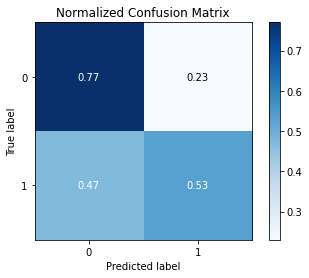

In [77]:
skplt.metrics.plot_confusion_matrix(target_test, predictions, normalize=True)
plt.show()

Согласно матрице ошибок мы видим, что показатель False Positive находится на уровне 0.23, что неплохо. Таким образом, наша модель допускает немного ошибок первого рода, и "невиновные "водители не будут слишком часто получать уведомления об опасности.

Однако, мы видим, что показатель False Negative находится на уровне 0.47, что достаточно высокий уровень ошибки. Но при этом, модель все равно чаще верно предсказывает виновность водителя, чем ошибается.

Теперь выведем полноту и точность на график, сравнив их с полученной F1-мерой:

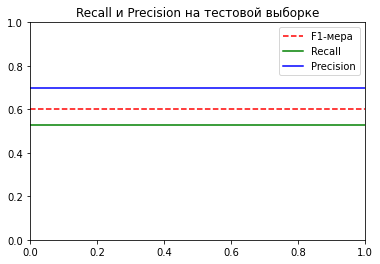

In [80]:
plt.axhline(f1_score(target_test, predictions), color = 'r', label='F1-мера', linestyle='--')
plt.axhline(recall_score(target_test, predictions), color = 'g',  label='Recall')
plt.axhline(precision_score(target_test, predictions), color = 'b', label='Precision')
plt.legend() 
plt.title('Recall и Precision на тестовой выборке')
plt.show()

Как мы видим, точность модели значительно выше, чем ее полнота. За счет этого агригирующая метрика F1 находится на уровне 0.6011.

Для анализа важности основных факторов, влияющих на вероятность ДТП, вызовем еще раз метод `profile_report()`. Во вкладке `Correlations-Auto` можно увидеть, что самая высокая степень корреляции между целевым признаком at_fault и party_sobriety (порядка 0.3):

In [85]:
data.profile_report(progress_bar=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Для признака `'party_sobriety'` проведем дополнительное исследование. Для этого построим график, который будет показывать долю виновности водителей от общего количества ДТП в зависимости от степени трезвости:

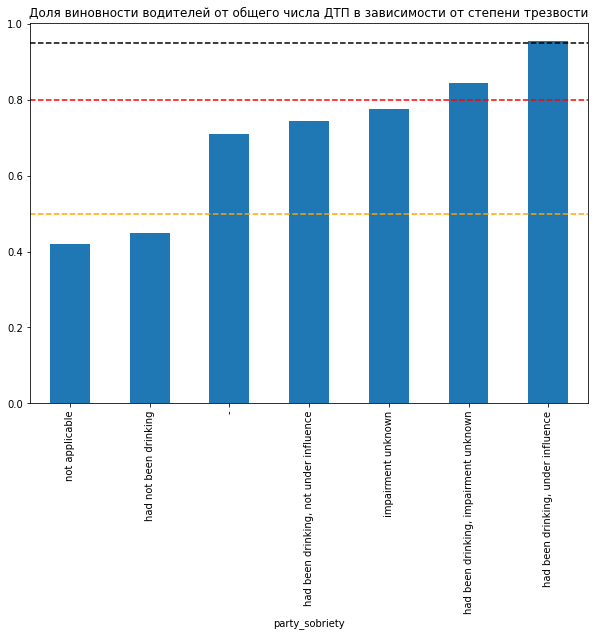

In [99]:
data.groupby('party_sobriety')['at_fault'].mean().sort_values().plot(kind='bar', figsize=(10,7), title='Доля виновности водителей от общего числа ДТП в зависимости от степени трезвости')
plt.axhline(0.5, color = 'orange',linestyle='--')
plt.axhline(0.8, color = 'r',linestyle='--')
plt.axhline(0.95, color = 'black',linestyle='--')

Как видим, если человек трезв, то он скорее всего не станет причиной ДТП (вероятность виновности порядка 0.45). Однако даже если водитель еще/уже не находится под влиянием алкоголя, но принимал его, то с вероятностью более 0.7 он станет виновником ДТП. А если он находится под влиянием алкоголя, то вероятность и вовсе находится на уровне близком к 1.

Поэтому заказчику необходимо дооборудовать автомобили, чтобы учесть этот фактор во время посадки водителя. В зависимости от бюджета можно приобрести различные анализаторы алкогольного опьянения. Если бюджет на дооснащение автомобилей сервиса не слишком ограничен, то помимо алкотестеров можно добавить камеру, чтобы исключить тестирование иного человека, кроме как водителя. 

Кроме того, можно минимизировать другие риски, которые известны до начала поездки. Например, чтобы освещение дороги не влияло на видимость на дороге, можно рекомендовать приобретать каршеринговые машины, которые будут иметь хорошую систему освещения (минимум светодиодные фары). Помимо этого в силах сервиса следить за техническим состоянием тормозной системы, шин автомобилей.

Помимо этого можно программно ограничить скорость движения автомобилей, например, до 100 км/ч. Можно совместить уже имеющиеся датчики GPS с ограничителем скорости, чтобы в рамках города скорость ограничивалась 60 км/ч, а за чертой - 100 км/ч.

А если сервис предоставляется в регионе, где возможны сильные снегопады и/или обледенение дорог, то можно оснастить машины специальными цепями на колеса, которые могут храниться в багажнике (они нужны, к примеру, чтобы ездить по дороге, которая полностью укрыта снегом).

## Общий вывод по модели

Лучшая модель - это модель градиентного бустинга LGBMClassifier, которая показала валидационной выборке значение F1-меры на уровне 0.617853 при при гиперпараметрах boosting_type='dart', learning_rate=0.01 и max_depth=8, а на тестовом наборе данных - 0.6011. 

При данных параметрах и постановке вопроса сложно создать адекадекватную системы оценки риска при выдаче авто, потому что:

1) При целевой переменной at_fault модель предсказывает вероятность **виновности водителя в ДТП**. Получается, что модель адекватно оценивает общий риск ДТП только при допущении, что люди попадают в аварию только тогда, когда сами в этом виноваты. Что не так.

2) Каршеринговый сервис не знает заранее по какому маршруту поедет водитель. Поэтому система не может дать рекомендации по маршруту, как того хотел заказчик. Представляется нереализуемой идея заставить клиентов строить маршрут на встроенных в каршеринговые авто навигаторы, потом следить, чтобы они не сбивались с намеченного маршрута. Непонятно, что должен делать сервис, если все же клиенты уходят с рекомендуемого/построенного маршрута. Система штрафов либо увеличение стоимости проката авто в таком случае маловероятно повысит привлекательность сервиса в глазах клиентов.

При этом усовершенствовать нашу модель можно. Для этого надо интегрировать данные о клиентах сервиса и их истории вождения авто. Например, их водительский стаж, наличие ДТП в прошлом, наличие штрафов от ГИБДД/ГАИ, факт постановки на учет в наркодиспансере и т.д.

